In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported")

Libraries imported


In [21]:
model_name = 'bert-base-uncased'
num_labels = 3
max_length = 128
batch_size = 16
num_epochs = 3
learning_rate = 2e-5
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [26]:
positive_texts = [
    "Company reports record quarterly profits, beating analyst expectations.",
    "Tech startup secures $50 million in Series B funding to expand operations.",
    "New product launch receives rave reviews from customers worldwide.",
    "Stock prices surge after successful merger announcement.",
    "Retail chain reports highest sales growth in a decade.",
    "Investor confidence rises as economic indicators show improvement.",
    "Company's innovative AI technology attracts global attention.",
    "Positive earnings call boosts shareholder optimism."
]

# Negative Sentences (1)
negative_texts = [
    "Company suffers major losses due to supply chain disruptions.",
    "Regulatory fines imposed after compliance violations discovered.",
    "Market reacts negatively to unexpected CEO resignation.",
    "Product recall leads to declining sales and damaged reputation.",
    "Shares plummet following disappointing quarterly earnings.",
    "Economic slowdown causes investor panic across markets.",
    "Data breach exposes millions of sensitive customer records.",
    "Production halted due to ongoing labor strikes."
]

# Neutral Sentences (2)
neutral_texts = [
    "The board scheduled the next annual general meeting for June.",
    "Company announced the appointment of a new Chief Financial Officer.",
    "Stock market opened relatively flat today amid low trading volume.",
    "Analysts expect moderate growth in the next fiscal quarter.",
    "The central bank issued its monthly economic report.",
    "Company released official minutes of the previous shareholders meeting.",
    "Trading was briefly suspended for scheduled system maintenance.",
    "No significant news from the corporation over the past week."
]

texts = positive_texts + negative_texts + neutral_texts
labels = [0]*len(positive_texts) + [1]*len(negative_texts) + [2]*len(neutral_texts)

# Duplicate to expand dataset
texts = texts * 20
labels = labels * 20

df = pd.DataFrame({'text': texts, 'label': labels})
print(f"Dataset size: {len(df)}")

# Label distribution
label_counts = df['label'].value_counts().sort_index()
print("Label distribution:")
for i, label_name in enumerate(['Positive','Negative','Neutral']):
    print(f"{label_name} ({i}): {label_counts[i]}")

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.2,
    random_state=seed,
    stratify=df['label'].values
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Dataset size: 480
Label distribution:
Positive (0): 160
Negative (1): 160
Neutral (2): 160
Training samples: 384
Validation samples: 96


In [27]:
tokenizer = BertTokenizer.from_pretrained(model_name)
print(f"Tokenizer loaded, vocab size: {tokenizer.vocab_size}")

Tokenizer loaded, vocab size: 30522


In [33]:
class FinancialDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Dataset class defined")

train_dataset = FinancialDataset(X_train, y_train, tokenizer, max_length)
val_dataset = FinancialDataset(X_val, y_val, tokenizer, max_length)

print(f"Train dataset: {len(train_dataset)}, Validation dataset: {len(val_dataset)}")

Dataset class defined
Train dataset: 384, Validation dataset: 96


In [36]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

print("BERT model loaded")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded


In [37]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,
    seed=seed,
    report_to="none"
)

print("Training arguments set")

Training arguments set


In [38]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

print("Trainer created")

Trainer created


In [39]:
print("Starting training...")
train_result = trainer.train()
print("Training completed!")

train_loss = train_result.metrics['train_loss']
print(f"Final training loss: {train_loss:.4f}")

Starting training...


Epoch,Training Loss,Validation Loss
1,1.167500,1.101989
2,0.972700,0.696414
3,0.620700,0.518276


Training completed!
Final training loss: 0.9432


Evaluating on validation set...


Validation loss: 0.5183
Validation Accuracy: 1.0000
Confusion Matrix:
 [[32  0  0]
 [ 0 32  0]
 [ 0  0 32]]


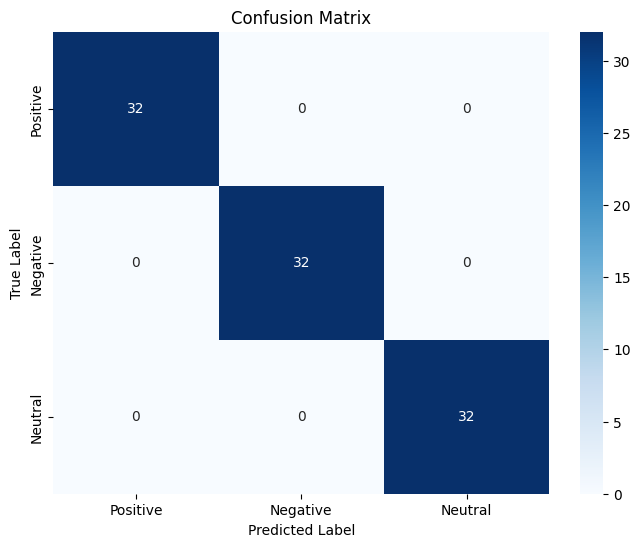


Classification Report:
              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00        32
    Negative       1.00      1.00      1.00        32
     Neutral       1.00      1.00      1.00        32

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



In [40]:
print("Evaluating on validation set...")
eval_results = trainer.evaluate()
print(f"Validation loss: {eval_results['eval_loss']:.4f}")

# Get predictions
predictions = trainer.predict(val_dataset)
predicted_probs = predictions.predictions
predicted_classes = np.argmax(predicted_probs, axis=1)
true_labels = predictions.label_ids

accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix
label_names = ['Positive','Negative','Neutral']
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=label_names))


In [41]:
test_sentences = [
    "Tech giant reports record-breaking revenue this quarter",
    "Unexpected drop in consumer demand causes stock prices to fall",
    "Board announces new policy updates for upcoming fiscal year"
]

print("\nTesting on new examples:")
for sentence in test_sentences:
    inputs = tokenizer(
        sentence,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    inputs = {k:v.to(model.device) for k,v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()
        confidence = torch.max(probs).item()

    print(f"\nText: {sentence}")
    print(f"Predicted class: {label_names[predicted_class]}, Confidence: {confidence:.4f}")
    print("All probabilities:", [round(p.item(),4) for p in probs[0]])



Testing on new examples:

Text: Tech giant reports record-breaking revenue this quarter
Predicted class: Positive, Confidence: 0.5049
All probabilities: [0.5049, 0.2723, 0.2228]

Text: Unexpected drop in consumer demand causes stock prices to fall
Predicted class: Negative, Confidence: 0.6289
All probabilities: [0.2608, 0.6289, 0.1102]

Text: Board announces new policy updates for upcoming fiscal year
Predicted class: Positive, Confidence: 0.4499
All probabilities: [0.4499, 0.2599, 0.2902]


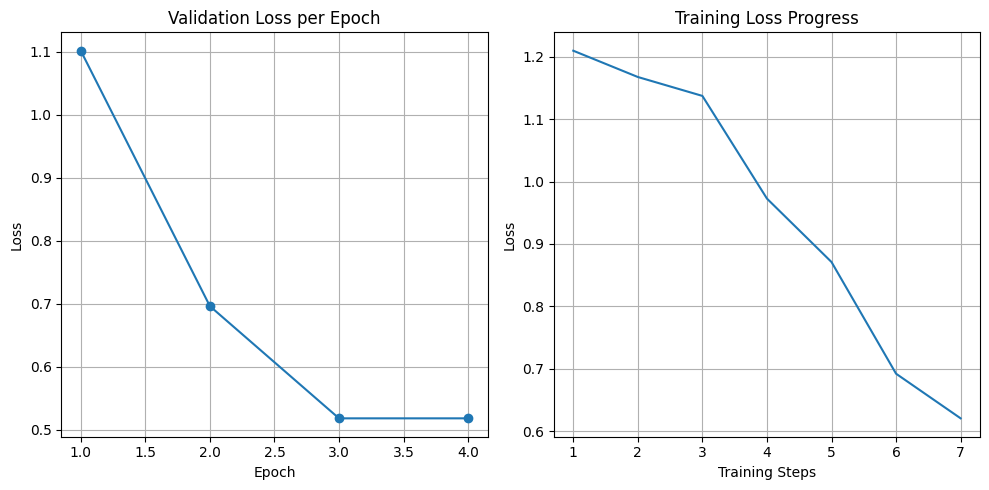

In [42]:
training_loss_history = []
validation_loss_history = []

for log in trainer.state.log_history:
    if 'loss' in log:
        training_loss_history.append(log['loss'])
    if 'eval_loss' in log:
        validation_loss_history.append(log['eval_loss'])

if len(validation_loss_history) > 0:
    plt.figure(figsize=(10,5))

    # Validation Loss
    plt.subplot(1,2,1)
    epochs = range(1,len(validation_loss_history)+1)
    plt.plot(epochs, validation_loss_history, 'o-', label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss per Epoch")
    plt.grid(True)

    # Training Loss
    if len(training_loss_history) > 0:
        plt.subplot(1,2,2)
        steps = range(1,len(training_loss_history)+1)
        plt.plot(steps, training_loss_history, label='Training Loss')
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Training Loss Progress")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [44]:
model_save_path = './financial_bert_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to: {model_save_path}")


# 14. LOAD MODEL

loaded_model = BertForSequenceClassification.from_pretrained(model_save_path).to(device)
loaded_tokenizer = BertTokenizer.from_pretrained(model_save_path)
loaded_model.eval()
print("Model loaded successfully")

test_text = "Stock prices soar after successful product launch"
inputs = loaded_tokenizer(test_text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = loaded_model(**inputs)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

print(f"\nTest with loaded model:")
print(f"Text: {test_text}")
print(f"Prediction: {label_names[predicted_class]}")

Model saved to: ./financial_bert_model
Model loaded successfully

Test with loaded model:
Text: Stock prices soar after successful product launch
Prediction: Positive
